# 算法链与管道

In [111]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
import mglearn
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

In [4]:
scaler = MinMaxScaler()
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

scaler.fit(X_train, y_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)

svc = SVC()
svc.fit(X_train_scaler, y_train)
print("The score of svc: {:.3f}".format(svc.score(X_test_scaler, y_test)))

对于svc算法而言，使用这一套逻辑，按照数据导入，数据放缩预处理，模型导入， 数据训练， 训练完成

## 使用预处理进行参数选择

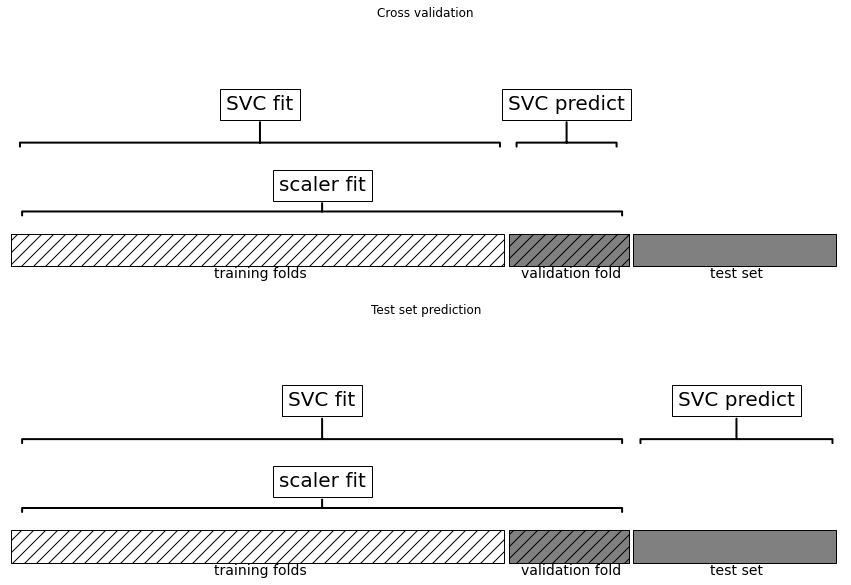

In [10]:
mglearn.plots.plot_improper_processing()

scaler会使用所有的训练集，如果在缩放之后再使用比如说GridSearch 或者是 Cross-Validation， 会使得在查找的过程中，是对训练集的划分，而此时的训练集已经使用过一部分训练集的信息了。交叉验证应该位于最外层。

## 构建管道

In [15]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])
pipe.fit(X_train, y_train)
print("The score of svc: {:.3f}".format(pipe.score(X_test, y_test)))

The score of svc: 0.972


## 在网格搜索中使用管道

In [20]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
             'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [27]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5) 
# 数据集一被放进来就会自动分成对应折，然后执行pipe里面的算法。
grid.fit(X_train, y_train)
print("The best parameters: {}".format(grid.best_params_))
print("The best score: {:.3f}".format(grid.best_score_))
print("Test score: {:.3f}".format(grid.score(X_train, y_train)))

The best parameters: {'svm__C': 1, 'svm__gamma': 1}
The best score: 0.981
Test score: 0.984


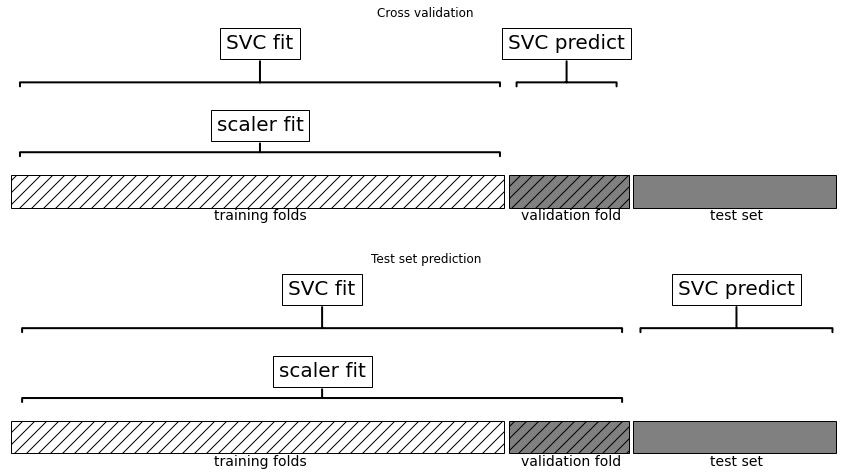

In [28]:
mglearn.plots.plot_proper_processing()

理解

## 使用make_pipeline创建管道

In [29]:
from sklearn.pipeline import make_pipeline

pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])

pipe_short = make_pipeline(MinMaxScaler, SVC(C=100))

In [31]:
print("Pipeline steps: \n{}".format(pipe_short.steps))

Pipeline steps: 
[('type', <class 'sklearn.preprocessing._data.MinMaxScaler'>), ('svc', SVC(C=100))]


### 访问步骤属性

In [41]:
pipe = make_pipeline(StandardScaler(), PCA(n_components=3), StandardScaler())
print("Pipe steps {}".format(pipe.steps))

Pipe steps [('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=3)), ('standardscaler-2', StandardScaler())]


In [43]:
pipe.fit(cancer.data)
components = pipe.named_steps["pca"].components_
print("Components shape: {}".format(components.shape))

Components shape: (3, 30)


In [46]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe.steps

[('standardscaler', StandardScaler()),
 ('logisticregression', LogisticRegression(max_iter=1000))]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
param_grid = {"logisticregression__C": [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best estimator: {}".format(grid.best_estimator_))

Best estimator: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])


In [52]:
print("Best estimator in logisticregression: {}".format(grid.best_estimator_.named_steps['logisticregression']))

Best estimator in logisticregression: LogisticRegression(C=1, max_iter=1000)


In [57]:
print("Best coef_ in logisticregression: \n{}".format(grid.best_estimator_.
                                    named_steps['logisticregression'].coef_))

Best coef_ in logisticregression: 
[[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


## 使用网格搜索预处理步骤与模型参数

In [62]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
pipe = make_pipeline(StandardScaler(), 
                    PolynomialFeatures(),
                    Ridge())

param_grid = {'polynomialfeatures__degree': [1, 2, 3],
             'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1) # 使用cpu的所有的核

In [63]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

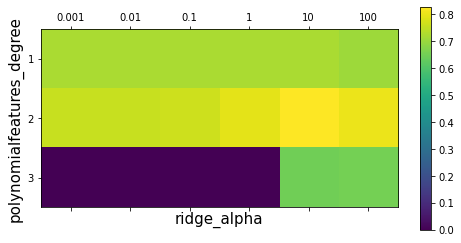

In [70]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
           vmin=0, cmap='viridis')
plt.xlabel("ridge_alpha", fontsize=15)
plt.ylabel("polynomialfeatures_degree", fontsize=15)
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])), param_grid['polynomialfeatures__degree'])
plt.colorbar()

In [77]:
pd.DataFrame(grid.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
mean_fit_time,0.00678506,0.00378981,0.0043879,0.00441504,0.00398035,0.00359178,0.0124656,0.00648479,0.00498772,0.00478759,0.00438814,0.00379028,0.0265695,0.0259302,0.0285233,0.024934,0.02613,0.023935
std_fit_time,0.00461764,0.000747284,0.0016229,0.000469959,9.45221e-06,0.000489695,0.00173775,0.00152182,4.52367e-07,0.000746328,0.000797904,0.000746647,0.00155906,0.00166864,0.00293178,0.0020919,0.00452297,0.00282003
mean_score_time,0.00159636,0.00119696,0.00159483,0.00159607,0.00139704,0.0015954,0.00178947,0.00178962,0.0009974,0.0019949,0.00139594,0.001197,0.00235314,0.00199537,0.0021945,0.00219445,0.00199447,0.00159535
std_score_time,0.00079937,0.000397993,0.000486617,0.000797856,0.000489962,0.000488664,0.000396442,0.000396156,6.32596e-07,0.000630453,0.000488812,0.000398804,0.000444912,7.13665e-07,0.000397994,0.000976445,1.83814e-06,0.000797796
param_polynomialfeatures__degree,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3
param_ridge__alpha,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100
params,"{'polynomialfeatures__degree': 1, 'ridge__alph...","{'polynomialfeatures__degree': 1, 'ridge__alph...","{'polynomialfeatures__degree': 1, 'ridge__alph...","{'polynomialfeatures__degree': 1, 'ridge__alph...","{'polynomialfeatures__degree': 1, 'ridge__alph...","{'polynomialfeatures__degree': 1, 'ridge__alph...","{'polynomialfeatures__degree': 2, 'ridge__alph...","{'polynomialfeatures__degree': 2, 'ridge__alph...","{'polynomialfeatures__degree': 2, 'ridge__alph...","{'polynomialfeatures__degree': 2, 'ridge__alph...","{'polynomialfeatures__degree': 2, 'ridge__alph...","{'polynomialfeatures__degree': 2, 'ridge__alph...","{'polynomialfeatures__degree': 3, 'ridge__alph...","{'polynomialfeatures__degree': 3, 'ridge__alph...","{'polynomialfeatures__degree': 3, 'ridge__alph...","{'polynomialfeatures__degree': 3, 'ridge__alph...","{'polynomialfeatures__degree': 3, 'ridge__alph...","{'polynomialfeatures__degree': 3, 'ridge__alph..."
split0_test_score,0.762602,0.762617,0.76276,0.76414,0.773967,0.781747,0.813194,0.816558,0.817204,0.831909,0.866518,0.871595,-1.12628,-0.389726,0.383167,0.831291,0.914146,0.905149
split1_test_score,0.56956,0.569557,0.569525,0.569216,0.567556,0.593544,0.639721,0.635223,0.641411,0.631069,0.618056,0.623519,-21.1772,-7.33049,-3.10899,-1.26858,-0.153154,0.264908
split2_test_score,0.779352,0.779353,0.77936,0.77941,0.778461,0.744269,0.631639,0.628425,0.627082,0.731638,0.877198,0.840461,-2883.05,-797.614,-64.5889,-1.33239,0.77717,0.343448


In [79]:
print("Best peremeters: {}".format(grid.best_estimator_))

Best peremeters: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('ridge', Ridge(alpha=10))])


In [81]:
print("Best permeters: {}".format(grid.best_params_))

Best permeters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [93]:
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))


Test score: 0.77


array([22.6, 50. , 23. ,  8.3, 21.2, 19.9, 20.6, 18.7, 16.1, 18.6,  8.8,
       17.2, 14.9, 10.5, 50. , 29. , 23. , 33.3, 29.4, 21. , 23.8, 19.1,
       20.4, 29.1, 19.3, 23.1, 19.6, 19.4, 38.7, 18.7, 14.6, 20. , 20.5,
       20.1, 23.6, 16.8,  5.6, 50. , 14.5, 13.3, 23.9, 20. , 19.8, 13.8,
       16.5, 21.6, 20.3, 17. , 11.8, 27.5, 15.6, 23.1, 24.3, 42.8, 15.6,
       21.7, 17.1, 17.2, 15. , 21.7, 18.6, 21. , 33.1, 31.5, 20.1, 29.8,
       15.2, 15. , 27.5, 22.6, 20. , 21.4, 23.5, 31.2, 23.7,  7.4, 48.3,
       24.4, 22.6, 18.3, 23.3, 17.1, 27.9, 44.8, 50. , 23. , 21.4, 10.2,
       23.3, 23.2, 18.9, 13.4, 21.9, 24.8, 11.9, 24.3, 13.8, 24.7, 14.1,
       18.7, 28.1, 19.8, 26.7, 21.7, 22. , 22.9, 10.4, 21.9, 20.6, 26.4,
       41.3, 17.2, 27.1, 20.4, 16.5, 24.4,  8.4, 23. ,  9.7, 50. , 30.5,
       12.3, 19.4, 21.2, 20.3, 18.8, 33.4])

In [112]:
pipe = make_pipeline(MinMaxScaler(), LinearRegression())
# Logisticregression is used for classification!!!!
pipe

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

In [113]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

In [115]:
print("Test score: {}".format(pipe.score(X_test, y_test)))


Test score: 0.6354638433202124
